### Import python libraries

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.utils import resample
import seaborn as sns

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from langdetect import detect

In [2]:
# merge Sherlock and Poirot data
df_h_p= pd.read_csv('./datasets/data_for_eda.csv')

## 1. EDA

### EDA 1 -> Eyeballing the data

In [3]:
# lets look at initial numbers for title

df_h_p.describe()

,subreddit
count,791.000000
mean,0.616941
std,0.486440
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [4]:
# lets look a few records
df_h_p.head()

,subreddit,title,selftext
0,0,Plz tell me Where do people watch poirot? I am...,Where do people watch poirot? I am from norway...
1,0,"My day started off a bit too similar ""Hercule ...",I was planning on watching the Suchet Christma...
2,0,Christmas day tradition!,NaN
3,0,Happy holidays!,NaN
4,0,What is your favorite most random scenes from ...,NaN


In [5]:
# lets look a few records
df_h_p.tail()

,subreddit,title,selftext
786,1,Or /r/Sherlock.,NaN
787,1,A proper gun for Holmes? Johnson Arms,NaN
788,1,"Awww. Really, society? I can't believe that th...",I can't believe that this is not a popular sub...
789,1,Who was more awesome? Sherlock Holmes or Fran...,NaN
790,1,What's your favorite Sherlock Holmes story?,NaN


### EDA 2 -> Compare Tokens per subreddit

In [6]:
# lets count the tokens in each title
df_h_p['tokens'] = [word_tokenize(i) for i in list(df_h_p['title'])]

df_h_p['tokens_len'] = [len(df_h_p.tokens[i]) for i in df_h_p.index ]

In [7]:
# lets look at initial numbers for title

df_h_p.groupby(by = 'subreddit')['tokens_len'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,303.0,64.125413,136.256469,2.0,10.0,22.0,69.50,1184.0
1,488.0,90.350410,267.944519,1.0,9.0,16.0,56.25,2322.0


### EDA 3 -> Average tokens per subreddit

In [8]:
# lets look at average length of tokens per subreddit
df_h_p.groupby(by = 'subreddit')['tokens_len'].mean()

subreddit
0    64.125413
1    90.350410
Name: tokens_len, dtype: float64

### EDA 4 -> Distribution of tokens per Subreddit

In [9]:
# lets look at distribution of words per subreddit
df_h_p[['subreddit' , 'tokens_len']]

,subreddit,tokens_len
0,0,23
1,0,83
2,0,4
3,0,3
4,0,13
...,...,...
786,1,3
787,1,8
788,1,66
789,1,23


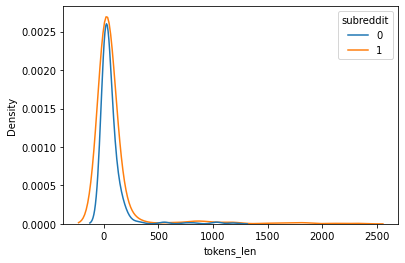

In [10]:
# Make default density plot
sns.kdeplot(data=df_h_p, x='tokens_len', hue="subreddit" );

##### Observation: The Subreddit 1 ( Sherlock) title has more titles with 10 tokens v.s Subreddit 0 (Poirot)

### EDA 5 -> Parts of Speech (POS) in the title and look at top 5 POS by Subreddit

In [11]:
title_df = list(df_h_p['title'])

In [12]:
# tokenize the messages using a vanilla NLTK word tokenizer
title_tokens = [word_tokenize(i) for i in title_df]

In [13]:
# part-of-speech tagging using the Penn Treebank tags
tagged_lst = [pos_tag(i) for i in title_tokens]

In [14]:
tagged_lst

[[('Plz', 'NNP'),
  ('tell', 'VB'),
  ('me', 'PRP'),
  ('Where', 'WRB'),
  ('do', 'VBP'),
  ('people', 'NNS'),
  ('watch', 'VB'),
  ('poirot', 'NN'),
  ('?', '.'),
  ('I', 'PRP'),
  ('am', 'VBP'),
  ('from', 'IN'),
  ('norway', 'NN'),
  ('and', 'CC'),
  ('i', 'NN'),
  ('can', 'MD'),
  ('find', 'VB'),
  ('it', 'PRP'),
  ('anywhere', 'RB'),
  ('.', '.'),
  ('Let', 'VB'),
  ('me', 'PRP'),
  ('know', 'VB')],
 [('My', 'PRP$'),
  ('day', 'NN'),
  ('started', 'VBD'),
  ('off', 'RP'),
  ('a', 'DT'),
  ('bit', 'NN'),
  ('too', 'RB'),
  ('similar', 'JJ'),
  ('``', '``'),
  ('Hercule', 'NNP'),
  ('Poirot', 'NNP'),
  ("'s", 'POS'),
  ('Christmas', 'NNP'),
  ("''", "''"),
  ('for', 'IN'),
  ('my', 'PRP$'),
  ('liking', 'NN'),
  ('.', '.'),
  ('I', 'PRP'),
  ('was', 'VBD'),
  ('planning', 'VBG'),
  ('on', 'IN'),
  ('watching', 'VBG'),
  ('the', 'DT'),
  ('Suchet', 'NNP'),
  ('Christmas', 'NNP'),
  ('episode', 'NN'),
  ('later', 'RBR'),
  ('this', 'DT'),
  ('evening', 'VBG'),
  ('with', 'IN'),
  ('di

In [15]:
# create a dictionary for the dataframe, lined up with the index positions of the messages
pos_dict = {}

for i in range(len(tagged_lst)):
    pos_dict[i] = dict(Counter(tag for  (token, tag) in tagged_lst[i]))


In [16]:
# lets look at the dictionary
pos_dict

{0: {'NNP': 1,
  'VB': 5,
  'PRP': 4,
  'WRB': 1,
  'VBP': 2,
  'NNS': 1,
  'NN': 3,
  '.': 2,
  'IN': 1,
  'CC': 1,
  'MD': 1,
  'RB': 1},
 1: {'PRP$': 4,
  'NN': 15,
  'VBD': 5,
  'RP': 1,
  'DT': 6,
  'RB': 7,
  'JJ': 3,
  '``': 1,
  'NNP': 5,
  'POS': 1,
  "''": 1,
  'IN': 7,
  '.': 5,
  'PRP': 5,
  'VBG': 5,
  'RBR': 1,
  'CC': 2,
  'TO': 3,
  'VB': 5,
  'VBP': 1},
 2: {'NNP': 1, 'NN': 2, '.': 1},
 3: {'JJ': 1, 'NNS': 1, '.': 1},
 4: {'WP': 1,
  'VBZ': 1,
  'PRP$': 1,
  'JJ': 2,
  'RBS': 1,
  'NNS': 1,
  'IN': 2,
  'NNP': 2,
  'NN': 1,
  '.': 1},
 5: {'NN': 16,
  'IN': 9,
  'NNP': 10,
  'CD': 2,
  '.': 12,
  'RB': 6,
  'JJ': 9,
  'VBN': 6,
  'DT': 12,
  'CC': 5,
  'VBG': 6,
  'PRP': 8,
  'VBP': 5,
  'WRB': 2,
  'VBZ': 2,
  ',': 4,
  'NNS': 5,
  'TO': 4,
  'VB': 4,
  'RP': 3,
  'WP': 2,
  'VBD': 8,
  'PRP$': 1},
 6: {'PRP': 1, 'VBZ': 1, 'DT': 3, 'JJ': 1, 'NN': 3, 'IN': 2},
 7: {'DT': 2,
  'NN': 3,
  'IN': 2,
  'NNP': 7,
  'CD': 2,
  "''": 1,
  'POS': 3,
  'VBZ': 1},
 8: {'VBN': 1,


In [17]:
# lets append all the dictionary data to the original data frame
df_h_p = pd.concat([df_h_p,pd.DataFrame(pos_dict).T ],axis = 1)

In [18]:
# lets look at the data
df_h_p.head()

,subreddit,title,selftext,tokens,tokens_len,NNP,VB,PRP,WRB,VBP,...,(,),JJS,#,JJR,$,WP$,FW,UH,SYM
0,0,Plz tell me Where do people watch poirot? I am...,Where do people watch poirot? I am from norway...,"[Plz, tell, me, Where, do, people, watch, poir...",23,1.0,5.0,4.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,"My day started off a bit too similar ""Hercule ...",I was planning on watching the Suchet Christma...,"[My, day, started, off, a, bit, too, similar, ...",83,5.0,5.0,5.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,Christmas day tradition!,NaN,"[Christmas, day, tradition, !]",4,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Happy holidays!,NaN,"[Happy, holidays, !]",3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,What is your favorite most random scenes from ...,NaN,"[What, is, your, favorite, most, random, scene...",13,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# lets create a new data frame with the columns were need
df_h_p_tok = df_h_p.drop(['title','selftext', 'tokens'], axis =1)


In [20]:
df_h_p_tok = df_h_p_tok.groupby(by = 'subreddit').sum().T

In [21]:
type(df_h_p_tok)

pandas.core.frame.DataFrame

In [22]:
# lets drop the first row
df_h_p_tok.drop(index = 'tokens_len', axis = 0 , inplace = True)

In [23]:
# Top 5 POS for Poirot
df_h_p_tok[0].sort_values(ascending = False).head(5)

NN     2365.0
NNP    1962.0
IN     1817.0
DT     1639.0
PRP    1253.0
Name: 0, dtype: float64

##### Observation: The Top 4  Parts of Speach for Poirot are :
##### NN -  Noun
##### NNP - Proper Noun 
##### IN - Preposition
##### DT - Determiner
##### PRP - Personal Pronoun

In [24]:
# Top 5 POS for Sherlock
df_h_p_tok[1].sort_values(ascending = False).head(5)

NN     5581.0
IN     4306.0
NNP    4303.0
DT     3915.0
JJ     2528.0
Name: 1, dtype: float64

##### Observation: The Top 4  Parts of Speach for Poirot are :
##### NN -  Noun
##### IN - Preposition
##### NNP - Proper Noun 
##### DT - Determiner
##### JJ - Adjective

In [25]:
df_h_p.head()

,subreddit,title,selftext,tokens,tokens_len,NNP,VB,PRP,WRB,VBP,...,(,),JJS,#,JJR,$,WP$,FW,UH,SYM
0,0,Plz tell me Where do people watch poirot? I am...,Where do people watch poirot? I am from norway...,"[Plz, tell, me, Where, do, people, watch, poir...",23,1.0,5.0,4.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,"My day started off a bit too similar ""Hercule ...",I was planning on watching the Suchet Christma...,"[My, day, started, off, a, bit, too, similar, ...",83,5.0,5.0,5.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,Christmas day tradition!,NaN,"[Christmas, day, tradition, !]",4,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Happy holidays!,NaN,"[Happy, holidays, !]",3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,What is your favorite most random scenes from ...,NaN,"[What, is, your, favorite, most, random, scene...",13,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Export the final data

In [26]:
# export the file to CSv
df_h_p.to_csv("./datasets/data_for_eda.csv", index=False)